In [1]:
import numpy as np
import pandas as pd
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
if __name__ == "__main__" and __package__ is None:
    from sys import path
    from os.path import dirname as dir

    path.append(dir(path[0]))
    __package__ = "examples"
from utils.date_utils import get_doy

### User input

In [12]:
savedir = '/media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/ARISE/Tanzania/S2-products'
year = '2022'
date_range = ('0101', '0428')  # (mindate: 'mmdd', maxdate: 'mmdd')
cloudcoverpercentage = (0, 70)   # (min %, max %)
minprodsize = 400                # Mb
numproducts = 60
tile = '37MDN'
platformname = 'Sentinel-2'
processinglevel = 'Level-1C'

### Read user credentials

In [13]:
cred = pd.read_csv("pw.csv", header=None)

### Query for Sentinel products

In [14]:
api = SentinelAPI(cred[0][0], cred[0][1], 'https://scihub.copernicus.eu/dhus')
print("querying...")
products = api.query(tileid=tile,
                     platformname=platformname,
                     cloudcoverpercentage=cloudcoverpercentage,
                     date=("%s%s" % (year, date_range[0]), "%s%s" % (year, date_range[1])),
                     processinglevel=processinglevel)
df = api.to_dataframe(products)
print("found %d products" % len(products))

querying...
found 10 products


### Remove very small size products

In [15]:
sizes = np.array([float(s.split(" ")[0]) for s in df['size'].values])
products2keep = OrderedDict()
for i, prodkey in enumerate(list(products.keys())):
    if sizes[i] >= minprodsize:
        # print(sizes[i])
        products2keep[prodkey] = products[prodkey]
df2keep = api.to_dataframe(products2keep).reset_index()
print("keeping %d products with larger than %dMb" % (len(products2keep), minprodsize))

if len(products2keep) < numproducts:
    print("number of products found (%d) is less than initially selected (%d)" % (len(products2keep), numproducts))
    print("changing number of selected products to %d" % (len(products2keep)))
    print("you may want to change selection criteria in 'User input' cell to find more products")
    numproducts = len(products2keep)

keeping 10 products with larger than 400Mb
number of products found (10) is less than initially selected (60)
changing number of selected products to 10
you may want to change selection criteria in 'User input' cell to find more products


### Spread products evenly in time and visualize

In [16]:
ccfactor = 0.0    # cloud cover factor when selecting products
def distance(doys, target_doy, ccfactor=0):
    """
    distance function for selecting products depending on 
    proximity to desired date and cloud cover
    """
    dist = np.abs(doys['doy'] - target_doy) + ccfactor * doys['cloudcoverpercentage']
    return dist

   doy       size cloudcoverpercentage
0    5  820.48 MB              55.1488
1   40  794.63 MB              9.41109
2   60  803.36 MB              33.9301
3   65  768.85 MB              47.6807
4   70  795.89 MB               36.565
5   75  784.40 MB              66.0153
6   85  812.33 MB              27.2806
7   95  819.05 MB              27.7287
8  100  806.83 MB              38.3053
9  115  782.31 MB              65.9704


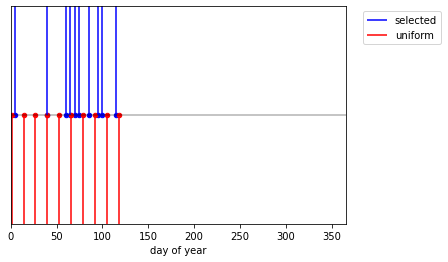

In [17]:
start_doy = get_doy("%s%s" % (year, date_range[0]))
end_doy = get_doy("%s%s" % (year, date_range[1]))
uniform_doy_list = np.linspace(start_doy, end_doy, numproducts).tolist()

doys = df2keep.copy()  # [['datatakesensingstart', 'cloudcoverpercentage', 'size']]
doys['doy'] = pd.DataFrame(
    doys['datatakesensingstart'].apply(lambda s: get_doy(str(s).split(' ')[0].replace('-', ''))))

idx_list = []
for doy_ in uniform_doy_list:
    # print(doy_)
    doys['distance'] = distance(doys, doy_, ccfactor)
    idx = doys['distance'].argmin()
    idx_list.append(pd.DataFrame(doys.iloc[idx, :]).T)
    doys = doys.drop(index=idx).reset_index(drop=True)
prod2keep = pd.concat(idx_list).reset_index(drop=True)  # df2keep.iloc[idx_list].reset_index(drop=True)
prod2keep['doy'] = pd.DataFrame(
    prod2keep['datatakesensingstart'].apply(lambda s: get_doy(str(s).split(' ')[0].replace('-', ''))))

# visualize
plt.scatter(prod2keep['doy'].values, np.zeros(prod2keep.shape[0]), s=20, c='b')
plt.scatter(uniform_doy_list, np.zeros(len(uniform_doy_list)), s=20, c='r')
plt.vlines(prod2keep['doy'].values, 0, 1, color='b', label='selected')
plt.vlines(uniform_doy_list, 0, -1, color='r', label='uniform')
plt.hlines(0, 1, 365, color='k', alpha=0.3)
plt.ylim(-1, 1)
plt.xlim(0, 365)
plt.yticks([], [])
plt.xlabel('day of year')
plt.legend(bbox_to_anchor=(1.3, 1))

# examine
print(prod2keep[['doy', 'size', 'cloudcoverpercentage']])  # .columns)

### Save selected products to disk

In [18]:
savename = '%s/%s_%s_tile%s_minsize%dMb_%ddates_year%s_from%sto%s_mincc%dmaxcc%d.csv' % \
           (savedir, platformname, processinglevel, tile, minprodsize, numproducts, year, 
            date_range[0], date_range[1], cloudcoverpercentage[0], cloudcoverpercentage[1])

if not os.path.exists(os.path.dirname(savename)):
    print("making new directory %s" % os.path.dirname(savename))
    os.makedirs(os.path.dirname(savename))

print("saving products info to %s" % savename)
prod2keep.to_csv(savename, index=False)

saving products info to /media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/ARISE/Tanzania/S2-products/Sentinel-2_Level-1C_tile37MDN_minsize400Mb_10dates_year2022_from0101to0428_mincc0maxcc70.csv
